# Regularized Linear Regression + Bias vs. Variance

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import scipy.optimize

### Regularized Linear Regression

In [2]:
datafile = os.getcwd() + '\ex5data1.mat'
mat = scipy.io.loadmat(datafile)

#Training Set
X, y = mat['X'], mat['y']
#Cross Validation Set
Xval, yval = mat['Xval'], mat['yval']
#Test set
Xtest, ytest = mat['Xtest'], mat['ytest']
#Insert column of 1's to all X's
X = np.insert(X, 0,1, axis=1)
Xval = np.insert(Xval, 0,1, axis=1)
Xtest = np.insert(Xtest, 0,1, axis=1)


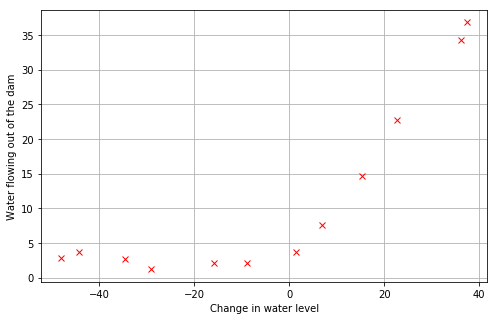

In [3]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam')
    plt.xlabel('Change in water level')
    plt.plot(X[:,1], y, 'rx')
    plt.grid(True)
plotData()

### Regularized Linear Regression (Cost Function)

In [4]:
def h(theta, X):
    return np.dot(X, theta)
def computeCost(mytheta, myX, myy, mylambda = 0):
    m = myX.shape[0]
    myh = h(mytheta, myX).reshape((m,1))
    mycost = float((1./(2*m)) * np.dot((myh-myy).T, (myh-myy)))
    regterm = (float(mylambda/(2*m))) * float(mytheta[1:].T.dot(mytheta[1:]))
    return mycost + regterm

In [5]:
mytheta = np.array([[1.], [1.]])
print (computeCost(mytheta, X, y, mylambda = 1))

303.9931922202643


### Regularized Linear Regression (Gradient)

In [6]:
def computeGradient(mytheta, myX, myy, mylambda = 0.):
    mytheta = mytheta.reshape((mytheta.shape[0],1))
    m = myX.shape[0]
    myh = h(mytheta, myX).reshape((m,1))
    grad = (1./float(m))*myX.T.dot(h(mytheta, myX)-myy)
    regterm = (float(mylambda)/m)*mytheta
    regterm[0] = 0 #Don't regularize bias term
    regterm.reshape((grad.shape[0],1))
    return grad + regterm
def computeGradientFlattened(mytheta, myX, myy, mylambda = 0.):
    return computeGradient(mytheta, myX, myy, mylambda = 0.).flatten()


In [7]:
mytheta = np.array([[1.], [1.]])
print (computeGradient(mytheta, X, y, 1.))

[[-15.30301567]
 [598.25074417]]


In [8]:
def optimizeTheta(myTheta_initial, myX, myy, mylambda=0., print_output = True):
    fit_theta = scipy.optimize.fmin_cg(computeCost, x0=myTheta_initial, fprime=computeGradientFlattened, args=(myX, myy, mylambda), disp = print_output, epsilon = 1.49e-12, maxiter = 1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0],1))
    return fit_theta


In [9]:
mytheta = np.array([[1.], [1.]])
fit_theta = optimizeTheta(mytheta, X, y, 0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


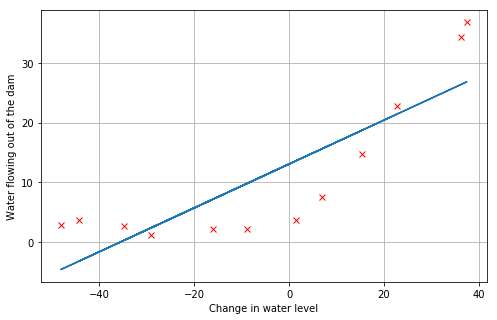

In [10]:
plotData()
plt.plot(X[:,1], h(fit_theta, X).flatten())

In [11]:
def plotLearningCurve():
    initial_theta = np.array([[1.], [1.]])
    mym, error_train, error_val = [], [], []
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, mylambda =0., print_output =False)
        error_train.append(computeCost(fit_theta, train_subset, y_subset, mylambda = 0.))
        error_val.append(computeCost(fit_theta, Xval, yval, mylambda = 0.))
    plt.figure(figsize=(8,5))
    plt.plot(mym, error_train, label ='Train')
    plt.plot(mym, error_val, label ='Cross Validation')
    plt.legend()
    plt.title('Learning Curve for Linear Regression')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Error')
    plt.grid(True)

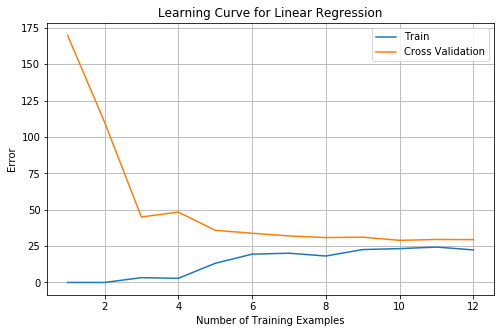

In [12]:
plotLearningCurve()

Above, you can see that as you increase the number of training examples, gap between Train and Cross Validation isn't too much. The model has a problem of high bias or underfitting the data

## Polynomial Regression

In [13]:
def genPolyFeatures(myX, p):
    newX = myX.copy()
    for i in range(p):
        dim = i + 2
        newX = np.insert(newX, newX.shape[1], np.power(newX[:,1], dim), axis = 1)
    return newX
def featureNormalize(myX):
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm, axis = 0)
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm, axis = 0, ddof = 1)
    Xnorm[:,1:] = Xnorm[:, 1:]/stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds

In [14]:
global_d = 5
newX = genPolyFeatures(X, global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)
mytheta = np.ones((newX_norm.shape[1], 1))
fit_theta = optimizeTheta(mytheta, newX_norm, y, 0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 279
         Function evaluations: 523
         Gradient evaluations: 523


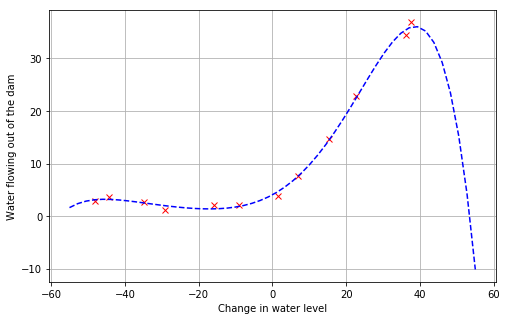

In [20]:
def plotFit(fit_theta, means, stds):
    #Function that takes in some learned fit values. 
    #1. Sets x-points as linspace 
    #2. Constructs appropriate X matrix 
    #3. Undoes previous feature normalization 
    #4. Computes hypothesis values 
    #5. Plots on top of data
    
    n_points_to_plot = 50
    xvals = np.linspace(-55, 55, n_points_to_plot)
    xmat = np.ones((n_points_to_plot, 1))
    
    xmat = np.insert(xmat, xmat.shape[1], xvals.T, axis = 1)
    xmat = genPolyFeatures(xmat, len(fit_theta)-2)
    
    #Undoing feature normalization
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plotData()
    plt.plot(xvals, h(fit_theta, xmat), 'b--')
    
plotFit(fit_theta, stored_means, stored_stds)
    

C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


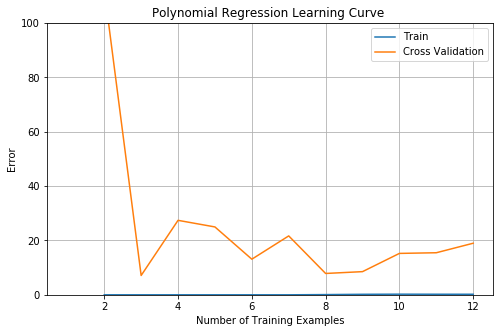

In [23]:
def plotPolyLearningCurve(mylambda = 0.):
    initial_theta = np.ones((global_d+2, 1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval, global_d))
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset, global_d)
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, mylambda = mylambda, print_output = False)
        error_train.append(computeCost(fit_theta, train_subset, y_subset, mylambda = mylambda))
        error_val.append(computeCost(fit_theta, myXval, yval, mylambda = mylambda))
    
    plt.figure(figsize=(8,5))
    plt.plot(mym, error_train, label = 'Train')
    plt.plot(mym, error_val, label = 'Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve ')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

## Playing Around with Regularization Parameter

## Lamba = 1

         Current function value: 8.042488
         Iterations: 5
         Function evaluations: 70
         Gradient evaluations: 59


C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


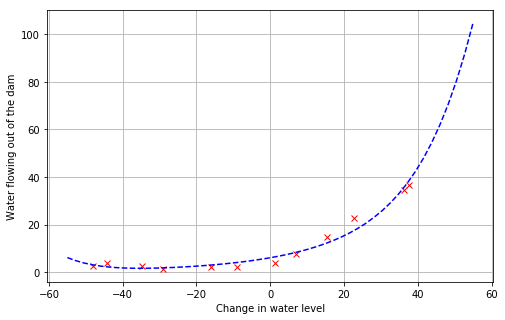

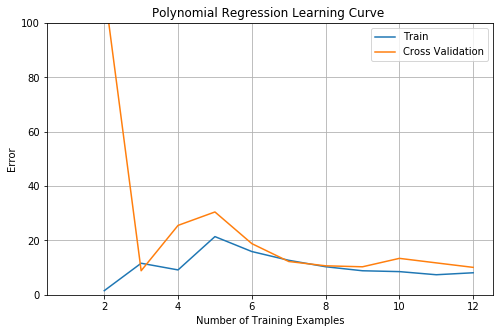

In [24]:
#Lambda = 1
mytheta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta, newX_norm, y, 1)
plotFit(fit_theta, stored_means, stored_stds)
plotPolyLearningCurve(1.)

## Lambda = 100

         Current function value: 135.643333
         Iterations: 0
         Function evaluations: 42
         Gradient evaluations: 30


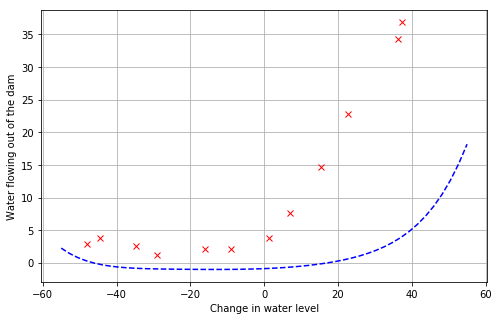

In [27]:
mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta, newX_norm, y, 100.)
plotFit(fit_theta, stored_means, stored_stds)

In [ ]:
#Selecting value for lambda using Cross Validation Set
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X, global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(Xval, global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(mytheta, newXtrain_norm, y, mylambda=mylambda)
    errors_train.append(computeCost(fit_theta, newXtrain_norm, y, mylambda=mylambda))
    errors_val.append(computeCost(fit_theta, newXval_norm, yval, mylambda=mylambda))
    

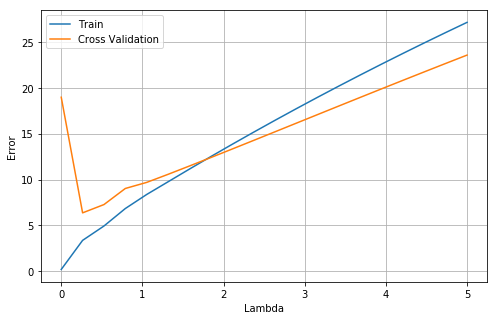

In [31]:
plt.figure(figsize=(8,5))
plt.plot(lambdas, errors_train, label='Train')
plt.plot(lambdas, errors_val, label='Cross Validation')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.grid(True)